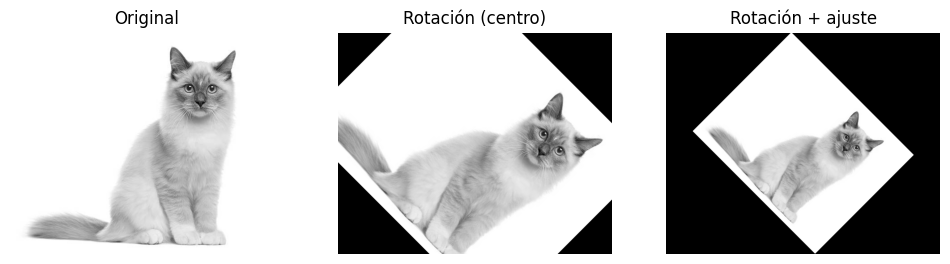

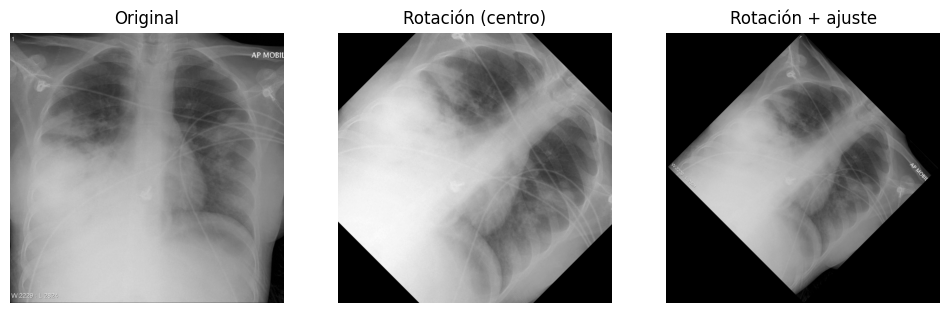

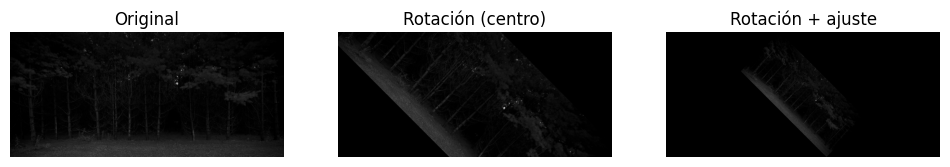

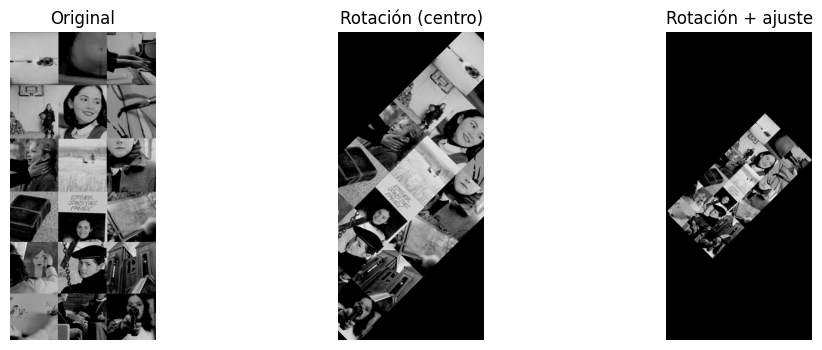

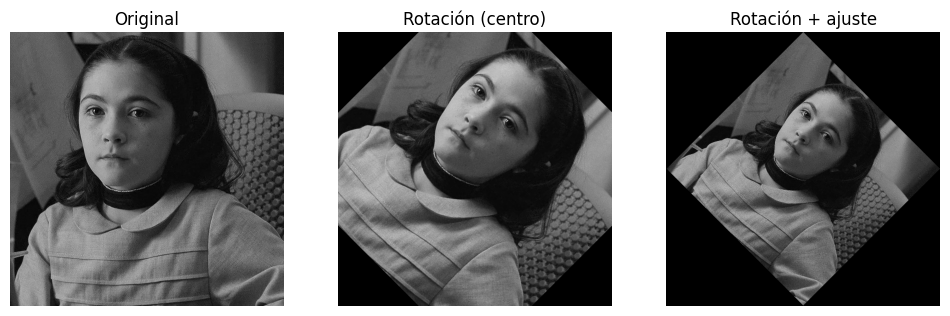

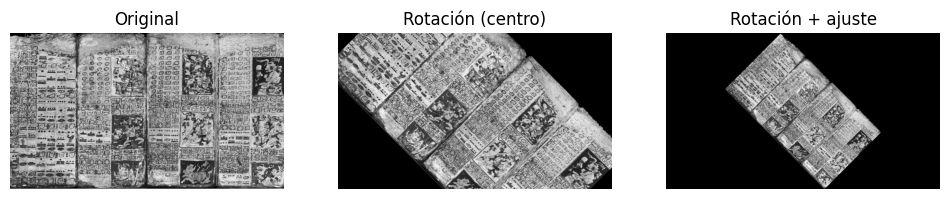

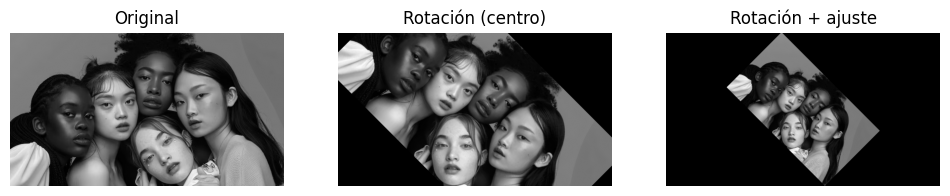

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math


# ----------------------------
# Interpolación bilineal
# ----------------------------
def bilinear_interpolation(img, x, y):
    h, w = img.shape
    
    if x < 0 or y < 0 or x >= w - 1 or y >= h - 1:
        return 0  # fuera de límites

    x1 = int(np.floor(x))
    y1 = int(np.floor(y))
    x2 = x1 + 1
    y2 = y1 + 1

    dx = x - x1
    dy = y - y1

    Q11 = img[y1, x1]
    Q12 = img[y2, x1]
    Q21 = img[y1, x2]
    Q22 = img[y2, x2]

    R1 = Q11 * (1 - dx) + Q21 * dx
    R2 = Q12 * (1 - dx) + Q22 * dx
    P = R1 * (1 - dy) + R2 * dy

    return int(P)


# ----------------------------
# Transformación afín manual
# ----------------------------
def affine_transform(img, M):
    h, w = img.shape
    out = np.zeros_like(img)

    # Matriz inversa para mapear cada pixel destino al origen
    Minv = np.linalg.inv(M)

    for y_out in range(h):
        for x_out in range(w):
            src = Minv @ np.array([x_out, y_out, 1])
            x_src, y_src = src[0], src[1]
            out[y_out, x_out] = bilinear_interpolation(img, x_src, y_src)

    return out


# ----------------------------
# Ajuste de tamaño para que no se salga al rotar
# ----------------------------
def compute_safe_scale(w, h, angle_deg):
    angle = math.radians(angle_deg)
    
    new_w = abs(w * math.cos(angle)) + abs(h * math.sin(angle))
    new_h = abs(w * math.sin(angle)) + abs(h * math.cos(angle))
    
    scale_w = w / new_w
    scale_h = h / new_h
    
    return min(scale_w, scale_h)


# ----------------------------
# Construir matriz afín centrada
# ----------------------------
def build_rotation_matrix_center(w, h, angle_deg, scale=1.0):
    angle = math.radians(angle_deg)
    cx, cy = w / 2, h / 2

    R = np.array([
        [ math.cos(angle), -math.sin(angle), 0],
        [ math.sin(angle),  math.cos(angle), 0],
        [ 0,               0,               1]
    ])

    S = np.array([
        [ scale, 0,     0],
        [ 0,     scale, 0],
        [ 0,     0,     1]
    ])

    T1 = np.array([
        [1, 0, -cx],
        [0, 1, -cy],
        [0, 0, 1]
    ])

    T2 = np.array([
        [1, 0, cx],
        [0, 1, cy],
        [0, 0, 1]
    ])

    M = T2 @ R @ S @ T1
    return M


# ----------------------------
# Procesar carpeta
# ----------------------------
def process_folder(folder, out_folder, angle=45):
    for filename in os.listdir(folder):
        if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        path = os.path.join(folder, filename)

        # cargar imagen en grises
        img = Image.open(path).convert("L")
        img_np = np.array(img)

        h, w = img_np.shape

        # 1️⃣ Rotación normal desde el centro
        M_center = build_rotation_matrix_center(w, h, angle)
        rotated = affine_transform(img_np, M_center)

        # 2️⃣ Rotación desde el centro + reescalado seguro
        scale = compute_safe_scale(w, h, angle)
        M_small = build_rotation_matrix_center(w, h, angle, scale)
        rotated_small = affine_transform(img_np, M_small)

        # Guardar salidas
        name, ext = os.path.splitext(filename)
        Image.fromarray(rotated).save(os.path.join(out_folder, f"{name}_rotacion{ext}"))
        Image.fromarray(rotated_small).save(os.path.join(out_folder, f"{name}_rotacion_safe{ext}"))

        # Mostrar
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_np, cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(rotated, cmap="gray")
        plt.title("Rotación (centro)")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(rotated_small, cmap="gray")
        plt.title("Rotación + ajuste")
        plt.axis("off")

        plt.show()



# 🔥 EJECUTAR
process_folder("./ImagenesCodigo", "./ImagenesCodigoSalidas", angle=45)
